In [389]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)

In [390]:
os.chdir('/Users/jed/Documents/JED/Dataiku/drive-download-20250106T224222Z-001')
!ls

census_income_additional_info.pdf census_income_metadata.txt
census_income_learn.csv           census_income_test.csv


In [391]:
#load the train and test datasets into pandas df
train_data=pd.read_csv('census_income_learn.csv', header=None)
test_data=pd.read_csv('census_income_test.csv', header=None)


In [392]:
if len(train_data.columns) == len(test_data.columns):
    print('Both train and test datasets have same no. of columns:', len(test_data.columns))

# There are no column/feature names, will need to add these from metadata.txt file
print('n= ', len(train_data), ' for the training dataset') 
print('n= ', len(test_data), ' for the testing dataset') 

Both train and test datasets have same no. of columns: 42
n=  199523  for the training dataset
n=  99762  for the testing dataset


In [393]:
# need to add column names from metadata.txt file
column_names=['AAGE',
 'ACLSWKR',
 'ADTIND',
 'ADTOCC',
 'AGI',
 'AHGA',
 'AHRSPAY',
 'AHSCOL',
 'AMARITL',
 'AMJIND',
 'AMJOCC',
 'ARACE',
 'AREORGN',
 'ASEX',
 'AUNMEM',
 'AUNTYPE',
 'AWKSTAT',
 'CAPGAIN',
 'CAPLOSS',
 'DIVVAL',
 'FEDTAX',
 'FILESTAT',
 'GRINREG',
 'GRINST',
 'HHDFMX',
 'HHDREL',
 'MARSUPWT',
 'MIGMTR1',
 'MIGMTR2',
 'MIGMTR4',
 'MIGSAME',
 'MIGSUN',
 'NOEMP',
 'PARENT',
 'PEARNVAL',
 'PEFNTVTY',
 'PEMNTVTY',
 'PENATVTY',
 'PRCITSHP',
 'PTOTVAL',
 'SEOTR',
 'TAXINC',
 'VETQVA',
 'VETYN',
 'WKSWORK']

# AGI column is adjusted gross income, which should be removed as it is the target feature
# so should FEDTAX, PERNVAL, PTOTVAL as they are all earning related columns 
# year of survey completion column name is missing from the txt file but is in the df
cols_to_remove=['AGI', 'FEDTAX','PEARNVAL','PTOTVAL','TAXINC', ]

for col in cols_to_remove:
    if col in column_names:
        column_names.remove(col)

column_names = column_names + ['YEAROFSUR']

# # assigned TARGET as the last column
column_names=column_names+['TARGET']

train_data.columns=column_names
test_data.columns=column_names

# # make the target variable binary as this is a binary classification task
train_data['TARGET_bin']=np.where(train_data.TARGET==' 50000+.',1,0)
test_data['TARGET_bin']=np.where(test_data.TARGET==' 50000+.',1,0)

# drop the original target variable
train_data.drop('TARGET', axis=1, inplace=True)
test_data.drop('TARGET', axis=1, inplace=True)
if len(column_names)== len(train_data.columns) == len(test_data.columns):
    print('Column names have been added to the train and test datasets')

Column names have been added to the train and test datasets


## Cleaning Data: removing duplicates, conflicting samples, outlier detection, missing data

In [394]:
# the metadata file describes a number of duplicated data points. Remove before continuing
# first step is to drop the weight column MARSUPWT as this is unique to each sample and will 
# influence the duplicate check

# check for duplicates in the training data

train_data=train_data.drop('MARSUPWT', axis=1)
dupes=train_data[train_data.duplicated(keep='first')]
print('---- Training data ----')
print('no. of duplicated samples = ',len(dupes))


# notice that the no. of duplicated samlpes without keeping the weight values is 10 times greater. By chance, the
# other features were similiar. 

# test data
test_data=test_data.drop('MARSUPWT', axis=1)
dupes=test_data[test_data.duplicated(keep='first')]
print('---- Test data ----')
print('no. of duplicated samples = ',len(dupes))


print('---- Before removing dupes ----')
print('Train: n=', len(train_data), 'Test: n=',  len(test_data))
# save the cleaned datasets
train_data=train_data.drop_duplicates()
test_data=test_data.drop_duplicates()

print('---- After removing dupes ----')
print('Train: n=', len(train_data), 'Test: n=',  len(test_data))

# train_data.to_csv('train_data_dupes_removed.csv', index=False)
# test_data.to_csv('test_data_dupes_removed.csv', index=False)

---- Training data ----
no. of duplicated samples =  46627
---- Test data ----
no. of duplicated samples =  20898
---- Before removing dupes ----
Train: n= 199523 Test: n= 99762
---- After removing dupes ----
Train: n= 152896 Test: n= 78864


In [395]:
# Metadat txt file said there are moore conflicting instances in the dataset.
# checking for samples where all features are the same but the target variable is different
print('---- Training Data ----')
df=train_data.copy()
# Identify conflicting instances
conflicting_instances = df[df.duplicated(subset=df.columns.difference(['TARGET_bin']), keep=False)]
print('no. of conflicting instances =',len(conflicting_instances))

# drop all conflicting instances, not enough information to decide which one to keep
df.drop_duplicates(subset=df.columns.difference(['TARGET_bin']), keep='first', inplace=True)
print('no. of samples after dropping conflicts = ',len(df))

train_data=df.copy()

print('---- Testing Data ----')
df=test_data.copy()
# Identify conflicting instances
conflicting_instances = df[df.duplicated(subset=df.columns.difference(['TARGET_bin']), keep=False)]
print('no. of conflicting instances =',len(conflicting_instances))

# drop all conflicting instances, not enough information to decide which one to keep
df.drop_duplicates(subset=df.columns.difference(['TARGET_bin']), keep='first', inplace=True)
print('no. of samples after dropping conflicts = ',len(df))
test_data=df.copy()

---- Training Data ----
no. of conflicting instances = 178
no. of samples after dropping conflicts =  152807
---- Testing Data ----
no. of conflicting instances = 76
no. of samples after dropping conflicts =  78826


### Outlier detection for continuous variables 
Age, Hours Worked, Weeks Worked

In [396]:
# save high earner and low earner data as sperate datasets to help with EDA
def update_earners_train (train_data):
    high_earner_data=train_data[train_data['TARGET_bin']==1]
    low_earner_data=train_data[train_data['TARGET_bin']==0]
    return high_earner_data, low_earner_data

def update_earners_test (test_data):
    high_earner_data_test=test_data[test_data['TARGET_bin']==1]
    low_earner_data_test=test_data[test_data['TARGET_bin']==0]
    return high_earner_data, low_earner_data



In [397]:
# dropping all values with age less than 15, as 15 years and over are classified as the 
# adult universe (ref: census_income_additional_info.pdf)

print('No. of samples in train and test sets = ',len(train_data), 'and', len(test_data))
train_data=train_data[train_data['AAGE'] > 14] 
test_data=test_data[test_data['AAGE'] > 14]
print('No. of samples in train and test sets = ',len(train_data), 'and', len(test_data))

No. of samples in train and test sets =  152807 and 78826
No. of samples in train and test sets =  140097 and 71562


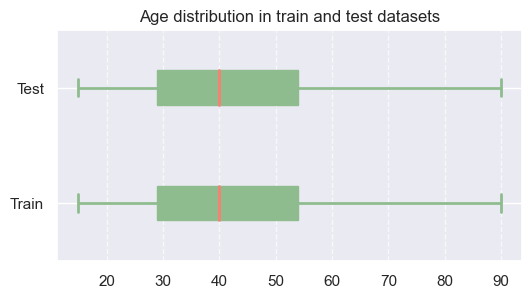

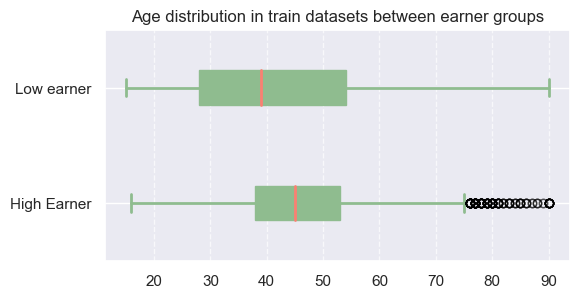

No changes made to the age feature or train and test datasets


In [398]:
# check for outliers the dataset
df=train_data.copy()

feature='AAGE'
train_age=df[feature]
test_age=df[feature]

# some predefined boxplot settings]
boxplot_settings = {

    'patch_artist': True, 
    'boxprops': dict(facecolor='darkseagreen', color='darkseagreen', linewidth=1),
    'whiskerprops': dict(color='darkseagreen', linewidth=2),
    'capprops': dict(color='darkseagreen', linewidth=2),
    'medianprops': dict(color='salmon', linewidth=2),
    'flierprops': dict(marker='o', color='lightseagreen', alpha=0.3),
    'widths': 0.3
}

plt.figure(figsize=(6, 3))
plt.boxplot([train_age, test_age], labels=['Train', 'Test'], vert=False, **boxplot_settings)
plt.title('Age distribution in train and test datasets')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



high_earner_data, low_earner_data=update_earners_train(df)
# check for outliers in the high and low earner datasets
plt.figure(figsize=(6, 3))
plt.boxplot([high_earner_data[feature], low_earner_data[feature]], labels=['High Earner', 'Low earner'], vert=False, **boxplot_settings)
plt.title('Age distribution in train datasets between earner groups')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# few outliers when looking at labels, I think it's ok
# leave for now, but can be removed using the code below if needed (TukeyIQR)

# label_age=np.array(train_data['AAGE'])
# q3 = np.percentile(label_age, 75)
# q1 = np.percentile(label_age, 25)
# iqr = q3 - q1

# ceiling = q3 + 1.5*iqr
# outliers = label_age[label_age > ceiling]
# print('Outliers: ', outliers)

print('No changes made to the age feature or train and test datasets')

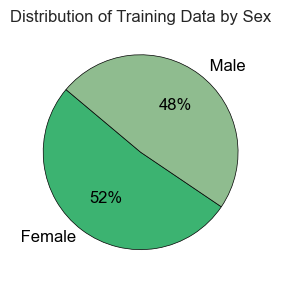

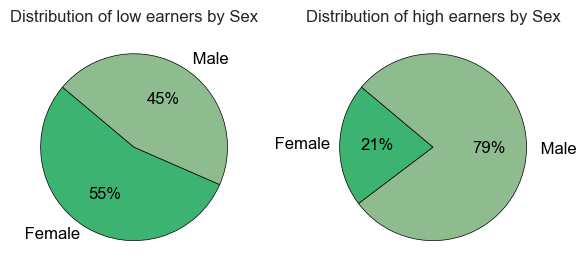

No changes made to the sex feature or train and test datasets


In [399]:
# Let's look at the distribution of sex across the target variable
df=train_data.copy()

feature='ASEX'
feature_name='Sex'
high_earner_data, low_earner_data=update_earners_train(df)

# whole dataset
category_counts = df[feature].value_counts().sort_index()

# Low earners
category_counts_low = low_earner_data[feature].value_counts().sort_index()

# High earners
category_counts_high = high_earner_data[feature].value_counts().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(6, 3))  # 1 row, 1 columns

#pie chart for all earners
axes.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=['mediumseagreen', 'darkseagreen'], #plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes.set_title("Distribution of Training Data by %s" % feature_name)
plt.tight_layout()
plt.show()

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # 1 row, 2 columns
# Pie chart for low earners
axes[0].pie(
    category_counts_low,
    labels=category_counts_low.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=['mediumseagreen', 'darkseagreen'], #plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes[0].set_title("Distribution of low earners by %s" % feature_name)

# Pie chart for high earners
axes[1].pie(
    category_counts_high,
    labels=category_counts_high.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=['mediumseagreen', 'darkseagreen'], #plt.cm.tab20c.colors, 
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6
)
axes[1].set_title("Distribution of high earners by %s" % feature_name)

# Adjust layout
plt.tight_layout()
plt.show()

print('No changes made to the sex feature or train and test datasets')

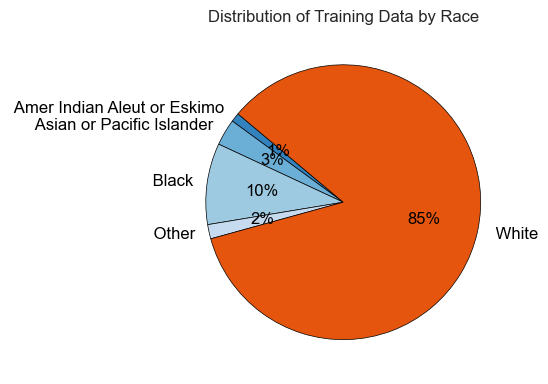

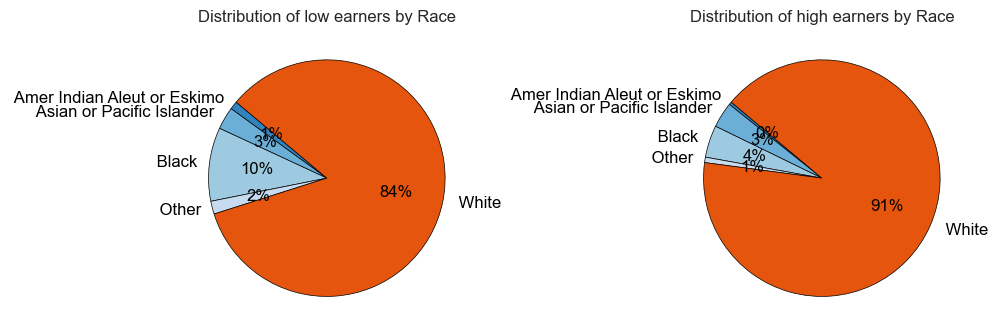

In [400]:
# Let's look at the distribution of sex across the target variable
df=train_data.copy()
df_test=test_data.copy()
feature='ARACE'
feature_name='Race'
high_earner_data, low_earner_data=update_earners_train(df)

# whole dataset
category_counts = df[feature].value_counts().sort_index()

# Low earners
category_counts_low = low_earner_data[feature].value_counts().sort_index()

# High earners
category_counts_high = high_earner_data[feature].value_counts().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4))  # 1 row, 1 columns

#pie chart for all earners
axes.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes.set_title("Distribution of Training Data by %s" % feature_name)
plt.tight_layout()
plt.show()

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Pie chart for low earners
axes[0].pie(
    category_counts_low,
    labels=category_counts_low.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes[0].set_title("Distribution of low earners by %s" % feature_name)

# Pie chart for high earners
axes[1].pie(
    category_counts_high,
    labels=category_counts_high.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors, 
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6
)
axes[1].set_title("Distribution of high earners by %s" % feature_name)

# Adjust layout
plt.tight_layout()
plt.show()

# will aggregate races that are non-white 

In [401]:
race_mapping = {
    ' White': 'White',
    ' Black': 'non_White', 
    ' Asian or Pacific Islander': 'non_White',
    ' Other': 'non_White',
    ' Amer Indian Aleut or Eskimo': 'non_White'
}

# apply new mapping to both train and test datasets
df['ARACE_eng'] = df['ARACE'].replace(race_mapping)
df_test['ARACE_eng'] = df_test['ARACE'].replace(race_mapping)

df['race_white'] = np.where(df['ARACE_eng'] == 'White', 1, 0)
df_test['race_white'] = np.where(df_test['ARACE_eng'] == 'White', 1, 0)

# drop 'ARACE' column as not needed 
df.drop('ARACE', axis=1, inplace=True)
df_test.drop('ARACE', axis=1, inplace=True)
df.drop('ARACE_eng', axis=1, inplace=True)
df_test.drop('ARACE_eng', axis=1, inplace=True)

# train and test datasets updates
train_data=df.copy()
test_data=df_test.copy()

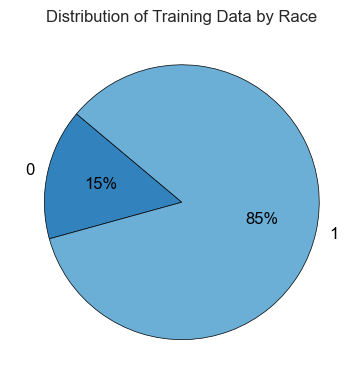

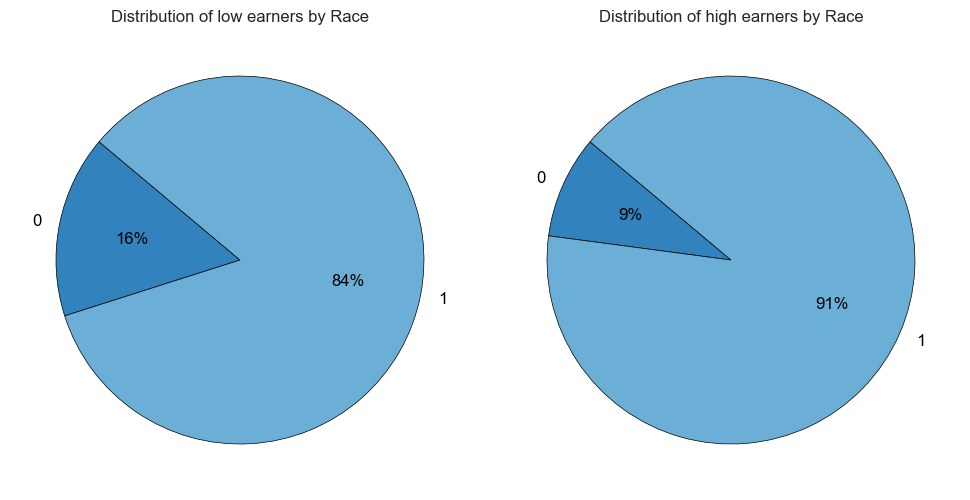

In [402]:
df=train_data.copy()
df_test=test_data.copy()
feature='race_white'
feature_name='Race'
high_earner_data, low_earner_data=update_earners_train(df)

# whole dataset
category_counts = df[feature].value_counts().sort_index()

# Low earners
category_counts_low = low_earner_data[feature].value_counts().sort_index()

# High earners
category_counts_high = high_earner_data[feature].value_counts().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4))  # 1 row, 1 columns

#pie chart for all earners
axes.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes.set_title("Distribution of Training Data by %s" % feature_name)
plt.tight_layout()
plt.show()

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Pie chart for low earners
axes[0].pie(
    category_counts_low,
    labels=category_counts_low.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes[0].set_title("Distribution of low earners by %s" % feature_name)

# Pie chart for high earners
axes[1].pie(
    category_counts_high,
    labels=category_counts_high.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors, 
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6
)
axes[1].set_title("Distribution of high earners by %s" % feature_name)

# Adjust layout
plt.tight_layout()
plt.show()

In [403]:
df=train_data.copy()
df_test=test_data.copy()

feature='AREORGN'
feature_name='Hispanic Origin'

# whole dataset
category_counts = df[feature].value_counts().sort_index()
print(category_counts)

# contains a lot of 'Other' values so not hugely informative, the Race categories
# should hopefully be enough for the modelling

# drop hispanic origin column
df.drop(feature, axis=1, inplace=True)
df_test.drop(feature, axis=1, inplace=True)

# train and test datasets updates
train_data=df.copy()
test_data=df_test.copy()


AREORGN
 All other                    121101
 Central or South American      2891
 Chicano                         186
 Cuban                           955
 Do not know                     250
 Mexican (Mexicano)             5332
 Mexican-American               4604
 NA                              700
 Other Spanish                  1849
 Puerto Rican                   2229
Name: count, dtype: int64


## Lineage

In [433]:
# We have country of birth data for mother, father and self. The majority are born in US
# We are going to combine features of mother and father so we will have three categories
# Both parents born in US, 1 parent (either mother or father) born in US, neither parents born in US. 

df=train_data.copy()
df_test=test_data.copy()

feature='PEFNTVTY'
feature_name='Father Birthplace'

# first replace values so that it is ones for US and zeros for not
df['US_father'] = np.where(df[feature] == ' United-States', 1, 0)
df_test['US_father'] = np.where(df_test[feature] == ' United-States', 1, 0)

feature='PEMNTVTY'
feature_name='Mother Birthplace'

# first replace values so that it is ones for US and zeros for not
df['US_Mother'] = np.where(df[feature] == ' United-States', 1, 0)
df_test['US_Mother'] = np.where(df_test[feature] == ' United-States', 1, 0)

# add the two columns to create an ordinal series (0=neither US born, 1=1xparent, 2=both)
df['Parents']=df['US_father'] + df['US_Mother']
df_test['Parents']=df_test['US_father'] + df_test['US_Mother']

# replace values so that it is 1 for >=1 or 0 for 0
df['Lineage'] = np.where(df['Parents'] >= 1, 1, 0)
df_test['Lineage'] = np.where(df_test['Parents'] >= 1, 1, 0)

train_data=df.copy()
test_data=df_test.copy()

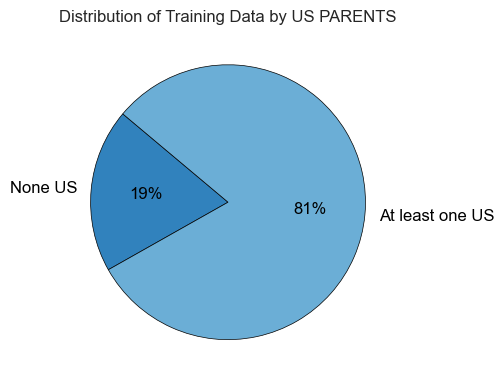

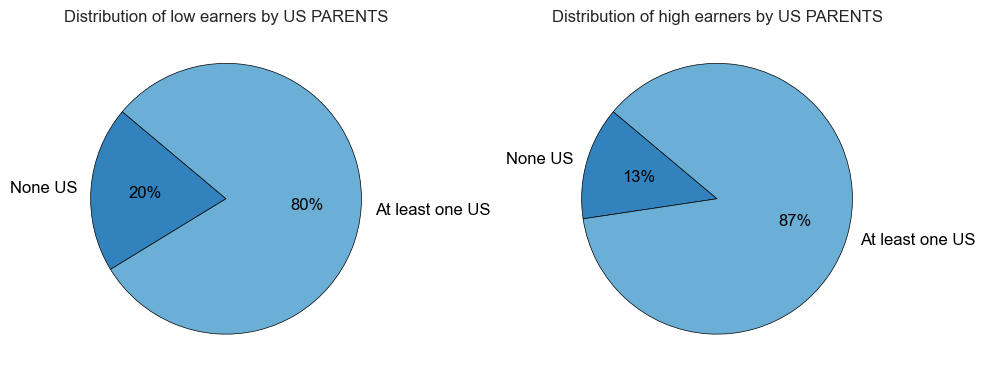

In [436]:
feature='Lineage'
feature_name='US PARENTS'
high_earner_data, low_earner_data=update_earners_train(df)

# whole dataset
category_counts = df[feature].value_counts().sort_index()

# Low earners
category_counts_low = low_earner_data[feature].value_counts().sort_index()

# High earners
category_counts_high = high_earner_data[feature].value_counts().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4))  # 1 row, 1 columns
labels=['None US', 'At least one US']
#pie chart for all earners
axes.pie(
    category_counts,
    labels=labels,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes.set_title("Distribution of Training Data by %s" % feature_name)
plt.tight_layout()
plt.show()

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Pie chart for low earners
axes[0].pie(
    category_counts_low,
    labels=labels,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes[0].set_title("Distribution of low earners by %s" % feature_name)

# Pie chart for high earners
axes[1].pie(
    category_counts_high,
    labels=labels,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors, 
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6
)
axes[1].set_title("Distribution of high earners by %s" % feature_name)

# Adjust layout
plt.tight_layout()
plt.show()

In [437]:
train_data.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL',
       'AMARITL', 'AMJIND', 'AMJOCC', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT',
       'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT', 'GRINREG', 'GRINST',
       'HHDFMX', 'HHDREL', 'MIGMTR1', 'MIGMTR2', 'MIGMTR4', 'MIGSAME',
       'MIGSUN', 'NOEMP', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY',
       'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK', 'YEAROFSUR',
       'TARGET_bin', 'race_white', 'US_father', 'US_Mother', 'Parents',
       'Lineage'],
      dtype='object')

In [ ]:
# identifying columns where ' Not in universe' is high
# and where ? are high  

df=train_data.copy()
# Initialize an empty dictionary to store the percentages
percentage_dict = {}

# Loop through each categorical column in the DataFrame
for column in df.select_dtypes(include=['object']).columns:
    # Calculate the percentage of 'Not in universe' for the current column
    percentage = (df[column] == ' Not in universe').mean() * 100
    percentage_dict[column] = percentage

# Sort the dictionary by percentages in descending order
sorted_percentage_dict = dict(sorted(percentage_dict.items(), key=lambda item: item[1], reverse=True))

# Print the columns and their percentages
for column, percentage in sorted_percentage_dict.items():
    if percentage > 0:
        print(f"{column}: {percentage:.2f}%")

# anything greater than %50 will be dropped
for column, percentage in sorted_percentage_dict.items():
    if percentage > 50:
        df.drop(column, axis=1, inplace=True)
        print(column, 'dropped from analysis')

VETQVA: 98.60%
PARENT: 96.09%
AUNTYPE: 95.71%
AHSCOL: 92.40%
GRINREG: 91.40%
GRINST: 91.40%
AUNMEM: 86.40%
MIGSUN: 41.55%
AMJOCC: 29.82%
ACLSWKR: 29.55%
VETQVA dropped from analysis
PARENT dropped from analysis
AUNTYPE dropped from analysis
AHSCOL dropped from analysis
GRINREG dropped from analysis
GRINST dropped from analysis
AUNMEM dropped from analysis


In [447]:
percentage_dict = {}

# Loop through each categorical column in the DataFrame
for column in df.select_dtypes(include=['object']).columns:
    # Calculate the percentage of 'Not in universe' for the current column
    percentage = (df[column] == ' ?').mean() * 100
    percentage_dict[column] = percentage

# Sort the dictionary by percentages in descending order
sorted_percentage_dict = dict(sorted(percentage_dict.items(), key=lambda item: item[1], reverse=True))

# Print the columns and their percentages
for column, percentage in sorted_percentage_dict.items():
    if percentage > 0:
        print(f"{column}: {percentage:.2f}%")

for column, percentage in sorted_percentage_dict.items():
    if percentage > 49.85:
        df.drop(column, axis=1, inplace=True)
        print(column, 'dropped from analysis')

MIGMTR1: 49.86%
MIGMTR2: 49.86%
MIGMTR4: 49.86%
MIGSUN: 49.86%
PEFNTVTY: 4.03%
PEMNTVTY: 3.64%
PENATVTY: 2.18%
MIGMTR1 dropped from analysis
MIGMTR2 dropped from analysis
MIGMTR4 dropped from analysis
MIGSUN dropped from analysis


In [448]:
df.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AMARITL',
       'AMJIND', 'AMJOCC', 'ASEX', 'AWKSTAT', 'CAPGAIN', 'CAPLOSS', 'DIVVAL',
       'FILESTAT', 'HHDFMX', 'HHDREL', 'MIGSAME', 'NOEMP', 'PEFNTVTY',
       'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETYN', 'WKSWORK',
       'YEAROFSUR', 'TARGET_bin', 'race_white', 'US_father', 'US_Mother',
       'Parents', 'Lineage'],
      dtype='object')

array(['HS-grad', 'HS-nongrad', 'Graduate', 'Grade-school'], dtype=object)

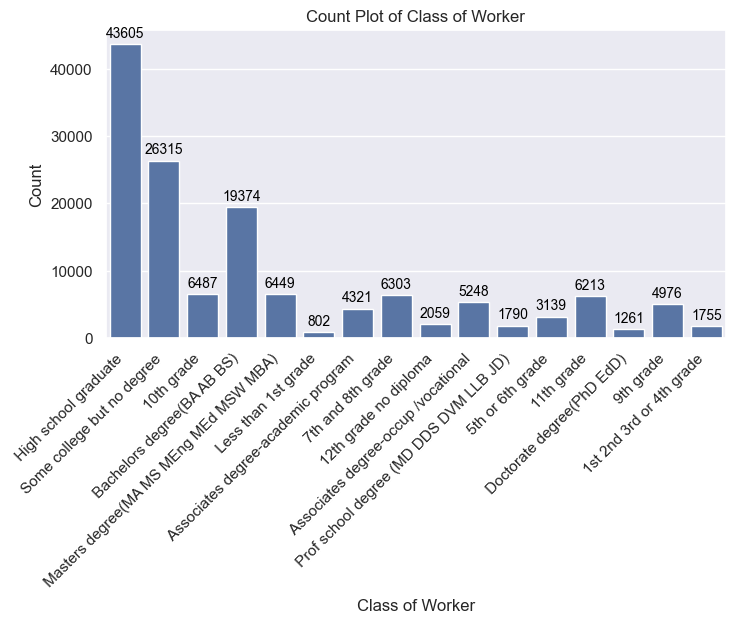

In [ ]:
df=train_data.copy()
df_test=test_data.copy()
sns.set()
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='EDU_eng', data=df)

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.title('Count Plot of Class of Worker')
plt.xlabel('Class of Worker')
plt.ylabel('Count')



education_mapping = {
' Less than 1st grade': 'Grade-school',
' 1st 2nd 3rd or 4th grade': 'Grade-school', 
' 5th or 6th grade': 'Grade-school', 
' 7th and 8th grade':'Grade-school', 
' 9th grade': 'HS-nongrad', 
' 10th grade': 'HS-nongrad',
' 11th grade': 'HS-nongrad', 
' 12th grade no diploma': 'HS-nongrad',
' High school graduate': 'HS-grad', 
' Associates degree-academic program': 'HS-grad',
' Associates degree-occup /vocational':'HS-grad',
' Some college but no degree': 'HS-grad',
' Bachelors degree(BA AB BS)': 'Graduate', 
' Masters degree(MA MS MEng MEd MSW MBA)': 'Graduate',
' Doctorate degree(PhD EdD)': 'Graduate',
' Prof school degree (MD DDS DVM LLB JD)': 'Graduate'
 }

 # apply new mapping to both train and test datasets
df['EDU_eng'] = df['AHGA'].replace(education_mapping)
df_test['EDU_eng'] = df_test['AHGA'].replace(education_mapping)

df['EDU_eng'].unique()

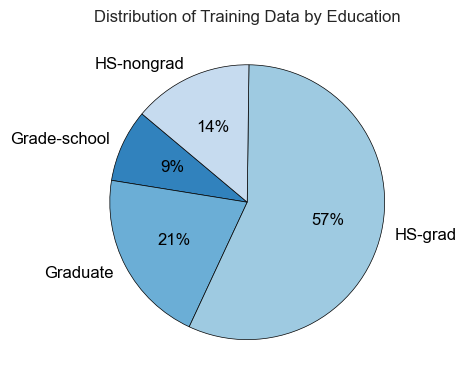

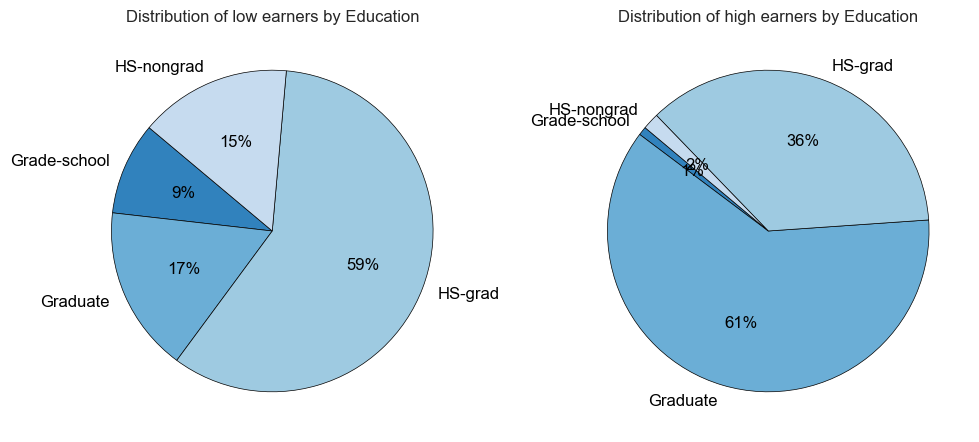

In [462]:
feature='EDU_eng'
feature_name='Education'
high_earner_data, low_earner_data=update_earners_train(df)

# whole dataset
category_counts = df[feature].value_counts().sort_index()

# Low earners
category_counts_low = low_earner_data[feature].value_counts().sort_index()

# High earners
category_counts_high = high_earner_data[feature].value_counts().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4))  # 1 row, 1 columns

#pie chart for all earners
axes.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes.set_title("Distribution of Training Data by %s" % feature_name)
plt.tight_layout()
plt.show()

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Pie chart for low earners
axes[0].pie(
    category_counts_low,
    labels=category_counts_low.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes[0].set_title("Distribution of low earners by %s" % feature_name)

# Pie chart for high earners
axes[1].pie(
    category_counts_high,
    labels=category_counts_high.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors, 
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6
)
axes[1].set_title("Distribution of high earners by %s" % feature_name)

# Adjust layout
plt.tight_layout()
plt.show()

In [465]:
from sklearn.preprocessing import OneHotEncoder
feature='EDU_eng'
#instantiate OneHotEncoder
encoder = OneHotEncoder(sparse=False) 

#fit and transform the column
encoded = encoder.fit_transform(df[[feature]])

# get the column names
column_names=[]
for i in sorted(df[feature].unique()):
    column_names.append('Education_{}'.format(i))

encoded_df = pd.DataFrame(encoded, columns=column_names)

df = df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
merged_df = df.join(encoded_df, how='left')

# drop the original column
merged_df.drop('EDU_eng', axis=1, inplace=True)

train_data=merged_df.copy()

# Test Dataset
#instantiate OneHotEncoder
encoder = OneHotEncoder(sparse=False) 

#fit and transform the column
encoded_test = encoder.fit_transform(df_test[[feature]])

# get the column names
column_names=[]
for i in sorted(df[feature].unique()):
    column_names.append('Education_{}'.format(i))

encoded_df_test = pd.DataFrame(encoded_test, columns=column_names)

df_test = df_test.reset_index(drop=True)
encoded_df_test = encoded_df_test.reset_index(drop=True)
merged_df_test = df_test.join(encoded_df_test, how='left')

# drop the original column
merged_df_test.drop('EDU_eng', axis=1, inplace=True)

test_data=merged_df_test.copy()

/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [466]:
train_data.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL',
       'AMARITL', 'AMJIND', 'AMJOCC', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT',
       'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT', 'GRINREG', 'GRINST',
       'HHDFMX', 'HHDREL', 'MIGMTR1', 'MIGMTR2', 'MIGMTR4', 'MIGSAME',
       'MIGSUN', 'NOEMP', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY',
       'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK', 'YEAROFSUR',
       'TARGET_bin', 'race_white', 'US_father', 'US_Mother', 'Parents',
       'Lineage', 'Education_Grade-school', 'Education_Graduate',
       'Education_HS-grad', 'Education_HS-nongrad'],
      dtype='object')

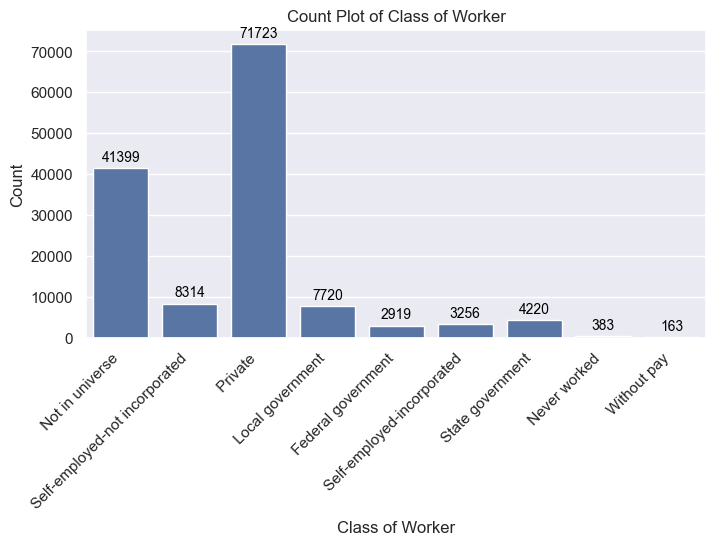

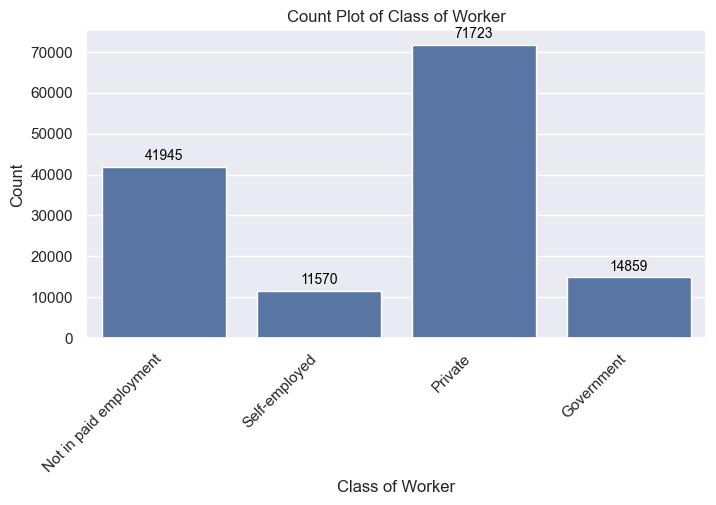

In [467]:
df=train_data.copy()

sns.set()
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='ACLSWKR', data=df)

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.title('Count Plot of Class of Worker')
plt.xlabel('Class of Worker')
plt.ylabel('Count')


# majority of individuals work for private companies
# the second largest group are not in currently employed (retired in the >50K group, young (<20) and retired in the <50K group)
# the third largest group are self employed individuals
# then government employees
# we will aggregate into 4 groups: private, not in paid employment (not in universe, never worked, without pay), self employed (inc and not), government (local, state, fed)
employment_mapping = {
    ' Private': 'Private',
    ' Self-employed-not incorporated': 'Self-employed',
    ' Self-employed-incorporated': 'Self-employed',
    ' Local government': 'Government',
    ' State government': 'Government',
    ' Federal government': 'Government',
    ' Not in universe': 'Not in paid employment',
    ' Never worked' : 'Not in paid employment',
    ' Without pay': 'Not in paid employment'
}

# apply new mapping to both train and test datasets
df['ACLSWKR_groups'] = df['ACLSWKR'].replace(employment_mapping)
# test_data['ACLSWKR_groups'] = test_data['ACLSWKR'].replace(employment_mapping)


# Plot the count plot of the aggregated groups
plt.figure(figsize=(8, 4))

ax = sns.countplot(x='ACLSWKR_groups', data=df)

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.title('Count Plot of Class of Worker')
plt.xlabel('Class of Worker')
plt.ylabel('Count')
plt.show()

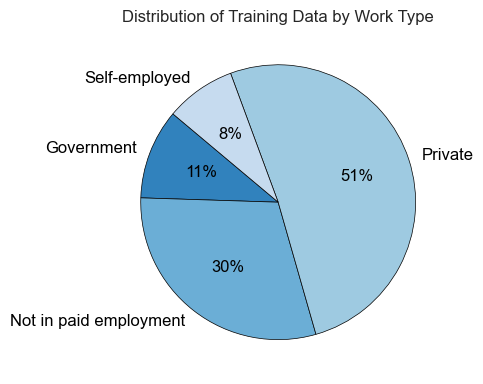

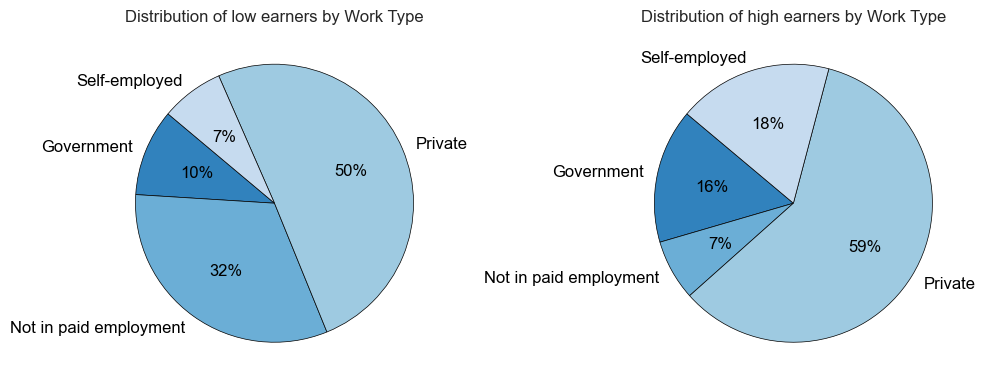

In [469]:
df=train_data.copy()
df_test=test_data.copy()
feature='ACLSWKR'
feature_name='Work Type'

employment_mapping = {
    ' Private': 'Private',
    ' Self-employed-not incorporated': 'Self-employed',
    ' Self-employed-incorporated': 'Self-employed',
    ' Local government': 'Government',
    ' State government': 'Government',
    ' Federal government': 'Government',
    ' Not in universe': 'Not in paid employment',
    ' Never worked' : 'Not in paid employment',
    ' Without pay': 'Not in paid employment'
}

# apply new mapping to both train and test datasets
df['ACLSWKR_groups'] = df['ACLSWKR'].replace(employment_mapping)

feature='ACLSWKR_groups'
high_earner_data, low_earner_data=update_earners_train(df)

# whole dataset
category_counts = df[feature].value_counts().sort_index()

# Low earners
category_counts_low = low_earner_data[feature].value_counts().sort_index()

# High earners
category_counts_high = high_earner_data[feature].value_counts().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4))  # 1 row, 1 columns

#pie chart for all earners
axes.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes.set_title("Distribution of Training Data by %s" % feature_name)
plt.tight_layout()
plt.show()

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Pie chart for low earners
axes[0].pie(
    category_counts_low,
    labels=category_counts_low.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes[0].set_title("Distribution of low earners by %s" % feature_name)

# Pie chart for high earners
axes[1].pie(
    category_counts_high,
    labels=category_counts_high.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors, 
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6
)
axes[1].set_title("Distribution of high earners by %s" % feature_name)

# Adjust layout
plt.tight_layout()
plt.show()

In [474]:
df.query("ACLSWKR_groups=='Not in paid employment' & TARGET_bin==1")

# 870 individuals have over 50K earnings but no job. This doesn't make sense, and cap gain and div is not 
# above 50K
# should i drop these samples, it's hard too understand why they are not in universe from the data we have
# 
print(len(df.query('TARGET_bin==1')) - 870) 

11450


In [475]:
df.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHRSPAY', 'AHSCOL',
       'AMARITL', 'AMJIND', 'AMJOCC', 'ASEX', 'AUNMEM', 'AUNTYPE', 'AWKSTAT',
       'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'FILESTAT', 'GRINREG', 'GRINST',
       'HHDFMX', 'HHDREL', 'MIGMTR1', 'MIGMTR2', 'MIGMTR4', 'MIGSAME',
       'MIGSUN', 'NOEMP', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY',
       'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK', 'YEAROFSUR',
       'TARGET_bin', 'race_white', 'US_father', 'US_Mother', 'Parents',
       'Lineage', 'Education_Grade-school', 'Education_Graduate',
       'Education_HS-grad', 'Education_HS-nongrad', 'ACLSWKR_groups'],
      dtype='object')

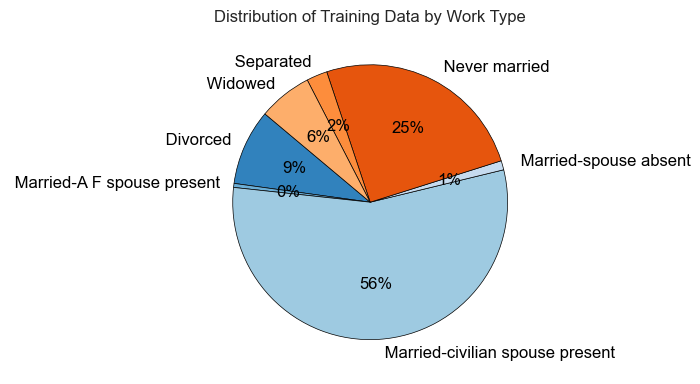

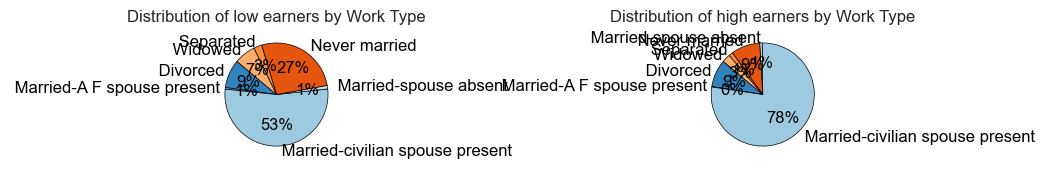

In [476]:
df=train_data.copy()
df_test=test_data.copy()
feature='AMARITL'
feature_name='Work Type'

high_earner_data, low_earner_data=update_earners_train(df)

# whole dataset
category_counts = df[feature].value_counts().sort_index()

# Low earners
category_counts_low = low_earner_data[feature].value_counts().sort_index()

# High earners
category_counts_high = high_earner_data[feature].value_counts().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4))  # 1 row, 1 columns

#pie chart for all earners
axes.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes.set_title("Distribution of Training Data by %s" % feature_name)
plt.tight_layout()
plt.show()

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Pie chart for low earners
axes[0].pie(
    category_counts_low,
    labels=category_counts_low.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes[0].set_title("Distribution of low earners by %s" % feature_name)

# Pie chart for high earners
axes[1].pie(
    category_counts_high,
    labels=category_counts_high.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors, 
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6
)
axes[1].set_title("Distribution of high earners by %s" % feature_name)

# Adjust layout
plt.tight_layout()
plt.show()

In [478]:
df['Married'] = np.where(df['AMARITL'] == ' Married-civilian spouse present', 1, 0)
df_test['Married'] = np.where(df_test['AMARITL'] == ' Married-civilian spouse present', 1, 0)

train_data=df.copy()
test_data=df_test.copy()

In [480]:
train_data.drop('AMARITL', axis=1, inplace=True)
test_data.drop('AMARITL', axis=1, inplace=True)

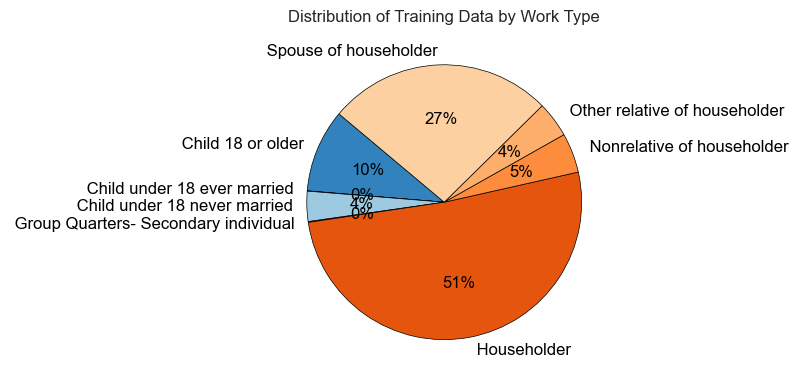

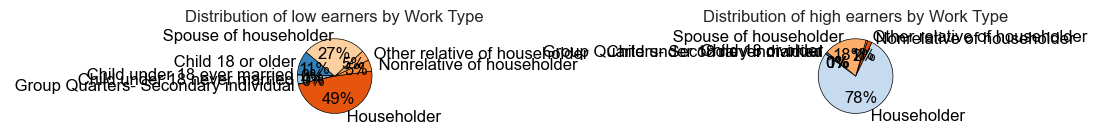

In [487]:
df=train_data.copy()
df_test=test_data.copy()
feature='HHDREL'
feature_name='Work Type'

high_earner_data, low_earner_data=update_earners_train(df)

# whole dataset
category_counts = df[feature].value_counts().sort_index()

# Low earners
category_counts_low = low_earner_data[feature].value_counts().sort_index()

# High earners
category_counts_high = high_earner_data[feature].value_counts().sort_index()

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 4))  # 1 row, 1 columns

#pie chart for all earners
axes.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes.set_title("Distribution of Training Data by %s" % feature_name)
plt.tight_layout()
plt.show()

# Create subplots

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
# Pie chart for low earners
axes[0].pie(
    category_counts_low,
    labels=category_counts_low.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors,  
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6

)
axes[0].set_title("Distribution of low earners by %s" % feature_name)

# Pie chart for high earners
axes[1].pie(
    category_counts_high,
    labels=category_counts_high.index,
    autopct='%1.0f%%',
    startangle=140,
    colors=plt.cm.tab20c.colors, 
    textprops={'fontsize': 12, 'color': 'black'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},
    labeldistance=1.1,
    pctdistance=0.6
)
axes[1].set_title("Distribution of high earners by %s" % feature_name)

# Adjust layout
plt.tight_layout()
plt.show()

In [488]:
df['Householder'] = np.where(df['HHDREL'] == ' Houoseholder', 1, 0)
df_test['Huoseholder'] = np.where(df_test['HHDREL'] == ' Householder', 1, 0)

df.drop('HHDREL', axis=1, inplace=True)
df_test.drop('HHDREL', axis=1, inplace=True)

train_data=df.copy()
test_data=df_test.copy()




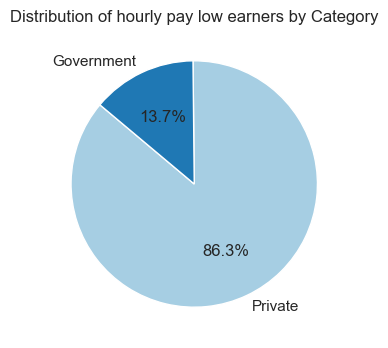

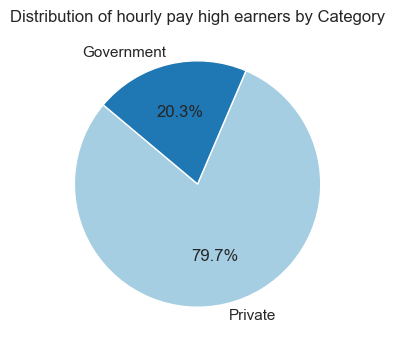

In [225]:
hour_pay_low_earner=df.query('AHRSPAY>0 & TARGET_bin ==0')
hour_pay_high_earner=df.query('AHRSPAY>0 & TARGET_bin ==1')
salary_low_earner=df.query("AHRSPAY==0 & ACLSWKR_groups != 'Not in paid employment'  & TARGET_bin ==0")
salary_high_earner=df.query("AHRSPAY==0 & ACLSWKR_groups != 'Not in paid employment'  & TARGET_bin ==1")


category_counts=hour_pay_low_earner['ACLSWKR_groups'].value_counts()
sns.set()
plt.figure(figsize=(8, 4))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',  # Show percentages on the chart
    startangle=140,  # Rotate the chart for better aesthetics
    colors=plt.cm.Paired.colors  # Optional: Use a color map
)
plt.title("Distribution of hourly pay low earners by Category")
plt.show()

category_counts=hour_pay_high_earner['ACLSWKR_groups'].value_counts()
sns.set()
plt.figure(figsize=(8, 4))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',  # Show percentages on the chart
    startangle=140,  # Rotate the chart for better aesthetics
    colors=plt.cm.Paired.colors  # Optional: Use a color map
)
plt.title("Distribution of hourly pay high earners by Category")
plt.show()

In [266]:
df.query('PENATVTY != " United-States" & PEFNTVTY == " United-States"')

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,ARACE,AREORGN,ASEX,AUNMEM,AUNTYPE,AWKSTAT,CAPGAIN,CAPLOSS,DIVVAL,FILESTAT,GRINREG,GRINST,HHDFMX,HHDREL,MIGMTR1,MIGMTR2,MIGMTR4,MIGSAME,MIGSUN,NOEMP,PARENT,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAROFSUR,TARGET_bin,ACLSWKR_groups
143,45,Private,34,3,Some college but no degree,0,Not in universe,Divorced,Finance insurance and real estate,Executive admin and managerial,White,Mexican (Mexicano),Female,Not in universe,Not in universe,Children or Armed Forces,0,0,16,Head of household,Not in universe,Not in universe,Householder,Householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,3,Not in universe,United-States,Mexico,Mexico,Native- Born abroad of American Parent(s),0,Not in universe,2,52,94,0,Private
261,27,Not in universe,0,0,High school graduate,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,3464,0,0,Joint both under 65,Abroad,Abroad,Householder,Householder,Abroad to nonMSA,Abroad,Abroad,No,No,6,Not in universe,United-States,United-States,Germany,Native- Born abroad of American Parent(s),0,Not in universe,2,52,94,0,Not in paid employment
508,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child under 18 of RP of unrel subfamily,Nonrelative of householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Mother only present,United-States,United-States,Germany,Native- Born abroad of American Parent(s),0,Not in universe,0,0,94,0,Not in paid employment
568,33,Private,30,2,Masters degree(MA MS MEng MEd MSW MBA),0,Not in universe,Married-civilian spouse present,Communications,Executive admin and managerial,White,All other,Female,Not in universe,Re-entrant,Children or Armed Forces,0,0,0,Joint both under 65,Northeast,South Carolina,Spouse of householder,Spouse of householder,MSA to MSA,Different county same state,Different county same state,No,No,6,Not in universe,United-States,Columbia,Columbia,Native- Born abroad of American Parent(s),0,Not in universe,2,23,94,0,Private
816,23,Private,4,34,7th and 8th grade,0,Not in universe,Never married,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Single,South,Georgia,Secondary individual,Nonrelative of householder,NonMSA to MSA,Different region,Different state in South,No,Yes,1,Not in universe,United-States,United-States,Germany,Native- Born abroad of American Parent(s),0,Not in universe,2,52,94,0,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198216,40,Self-employed-not incorporated,44,32,Some college but no degree,0,Not in universe,Married-civilian spouse present,Social services,Other service,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,Nonmover,Nonmover,Nonmover,Yes,Not in universe,1,Not in universe,United-States,United-States,Japan,Native- Born abroad of American Parent(s),0,Not in universe,2,52,94,0,Self-employed
198514,29,Private,33,8,Bachelors degree(BA AB BS),2755,Not in universe,Married-civilian spouse present,Retail trade,Professional specialty,White,All other,Female,No,Not in universe,Children or Armed Forces,0,0,50,Joint both under 65,Northeast,?,Householder,Householder,MSA to MSA,Different state same division,Different state in Northeast,No,No,0,Not in universe,United-States,United-States,?,Native- Born abroad of American Parent(s),0,Not in universe,2,0,94,0,Private
198744,27,Federal government,50,1,Some college but no degree,1000,Not

In [277]:
low_earner_data['AAGE'].describe()

count    140487.000000
mean         39.137486
std          20.102702
min           0.000000
25%          24.000000
50%          37.000000
75%          52.000000
max          90.000000
Name: AAGE, dtype: float64

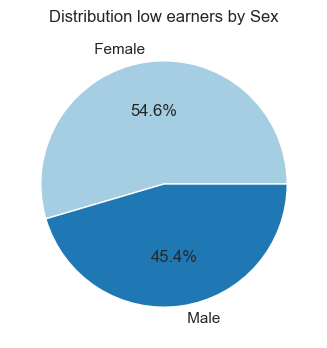

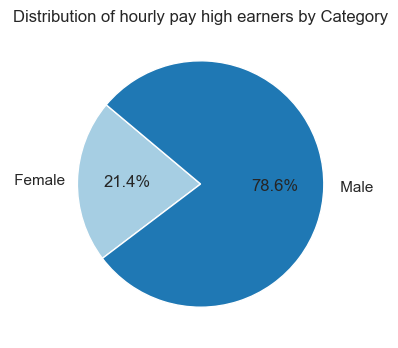

VETYN
2    126043
1      1734
Name: count, dtype: int64


In [287]:
hour_pay_low_earner=df.query('AHRSPAY>0 & TARGET_bin ==0')
hour_pay_high_earner=df.query('AHRSPAY>0 & TARGET_bin ==1')
salary_low_earner=df.query("AHRSPAY==0 & ACLSWKR_groups != 'Not in paid employment'  & TARGET_bin ==0")
salary_high_earner=df.query("AHRSPAY==0 & ACLSWKR_groups != 'Not in paid employment'  & TARGET_bin ==1")

feature='ASEX'
feature_name='Sex'
category_counts=low_earner_data[feature].value_counts().sort_index()
sns.set()
plt.figure(figsize=(8, 4))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',  # Show percentages on the chart
    startangle=140,
    colors=plt.cm.Paired.colors 
)
plt.title("Distribution low earners by %s" % feature_name)
plt.show()

category_counts=high_earner_data[feature].value_counts().sort_index()
plt.figure(figsize=(8, 4))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',  # Show percentages on the chart
    startangle=140,  # Rotate the chart for better aesthetics
    colors=plt.cm.Paired.colors  # Optional: Use a color map
)
plt.title("Distribution of high earners by %s" % feature_name)
plt.show()



In [228]:
category_counts=salary_low_earner['ACLSWKR_groups'].value_counts()
category_counts

ACLSWKR_groups
Private          55145
Government       11458
Self-employed     9353
Name: count, dtype: int64

Text(0, 0.5, 'Count')

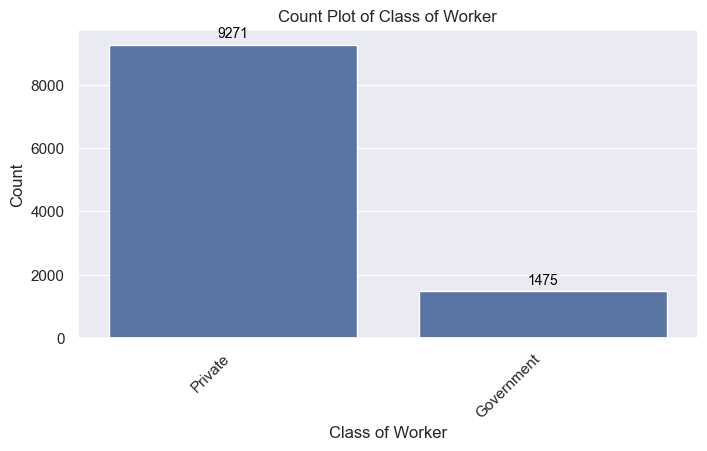

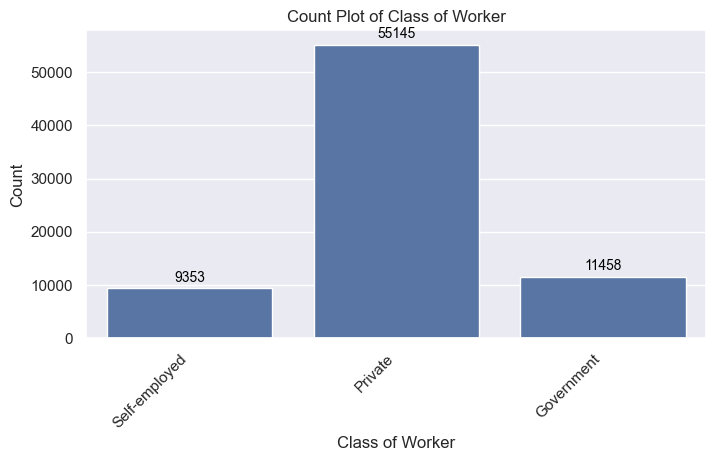

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt
# df=train_data.copy()

hour_pay_low_earner=df.query('AHRSPAY>0 & TARGET_bin ==0')
hour_pay_high_earner=df.query('AHRSPAY>0 & TARGET_bin ==1')
salary_low_earner=df.query("AHRSPAY==0 & ACLSWKR_groups != 'Not in paid employment'  & TARGET_bin ==0")
salary_high_earner=df.query("AHRSPAY==0 & ACLSWKR_groups != 'Not in paid employment'  & TARGET_bin ==1")


category_counts=hour_pay_low_earner['ACLSWKR_groups'].value_counts()
sns.set()
plt.figure(figsize=(8, 4))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',  # Show percentages on the chart
    startangle=140,  # Rotate the chart for better aesthetics
    colors=plt.cm.Paired.colors  # Optional: Use a color map
)



ax = sns.countplot(x='ACLSWKR_groups', data=hour_pay_low_earner)

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.title('Count Plot of Class of Worker')
plt.xlabel('Class of Worker')
plt.ylabel('Count')

sns.set()
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='ACLSWKR_groups', data=salary_low_earner)

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.title('Count Plot of Class of Worker')
plt.xlabel('Class of Worker')
plt.ylabel('Count')



In [212]:
df=train_data.copy()

# check for outliers in the hourspay looking at summary stats and feature boxplots


hrspay_train=df['AHRSPAY']


print(hrspay_train.describe())
# we see that the max value is 9999, which is a ceiling value. The hourly pay should
# have a decimal place. $99.99 per hour which is a reasonable value. Looking at the datasheet

df['AHRSPAY']=df['AHRSPAY']/100
print(df['AHRSPAY'].describe())

high_earner_data, low_earner_data=update_earners_train(df)
# count the number of samples with 0 hourly pay
print(high_earner_data['AHRSPAY'].value_counts())

print(low_earner_data.query('AHRSPAY  >0')['AHRSPAY'].describe())
print(high_earner_data.query('AHRSPAY  >0')['AHRSPAY'].describe())
# feature='AHRSPAY'
# plt.boxplot([high_earner_data[feature], low_earner_data[feature]], labels=['High Earner', 'Low earner'], vert=False, **boxplot_settings)
# plt.title('Age distribution in train datasets between earner groups')
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.show()



#141505 samples have 0 as hourly pay, which is not plausile
# we will drop this column as it is not useful for the model
# we will also drop the column from the test dataset
# train_data.drop('AHRSPAY', axis=1, inplace=True)
# test_data.drop('AHRSPAY', axis=1, inplace=True)

count    152807.000000
mean         72.366403
std         312.158434
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        9999.000000
Name: AHRSPAY, dtype: float64
count    152807.000000
mean          0.723664
std           3.121584
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          99.990000
Name: AHRSPAY, dtype: float64
AHRSPAY
0.00     11764
20.00       26
18.00       25
22.00       20
25.00       19
         ...  
12.51        1
10.67        1
12.70        1
15.84        1
21.88        1
Name: count, Length: 228, dtype: int64
count    10746.000000
mean         9.349733
std          6.032237
min          0.200000
25%          5.750000
50%          8.000000
75%         11.300000
max         99.160000
Name: AHRSPAY, dtype: float64
count    556.000000
mean      18.181115
std        9.940861
min        1.000000
25%       11.847500
50%       18.000000
75%       22.500000
max       99.9

In [173]:
print(len(train_data['CAPGAIN'].loc[lambda x : x == 15024]))
print(train_data['CAPGAIN'].value_counts()[:10], '\n')
# I am inclined not to trust this column. As it has 390 99999 values. 
# Hard to tell if this should be converted to 0, as it is missing or if it means another error. 
# also random amounts such as 15024, 7688, 7298 seem to be highly frequent. 
# Not sure I can trust this column. 


788
CAPGAIN
0        145433
15024       788
7688        609
7298        582
99999       390
3103        237
5178        207
5013        158
4386        151
3325        121
Name: count, dtype: int64 



In [174]:
print(len(train_data['CAPLOSS'].loc[lambda x : x == 0]))
print(train_data['CAPLOSS'].value_counts()[:10], '\n')
# I am inclined not to trust this column. As it has 390 99999 values. 
# Hard to tell if this should be converted to 0, as it is missing or if it means another error. 


148902
CAPLOSS
0       148902
1902       407
1977       381
1887       364
1602       193
2415       122
1485        95
1848        88
1876        87
1672        85
Name: count, dtype: int64 



In [175]:
print(train_data['DIVVAL'].loc[lambda x : x == 99999].index)
print(train_data['DIVVAL'].value_counts()[:30], '\n')
# these values seem more sensible. only a small number of 99999 values.
# I will keep this column for now.
# explore the 99999 values to see if they relate to the label. 

div9_cases=train_data['DIVVAL'].loc[lambda x : x == 99999].index
train_data.loc[div9_cases]
with9s_removed=high_earner_data.query('DIVVAL < 99999')
with9s_removed['DIVVAL'].value_counts()


Index([   991,   8921,  13733,  14914,  22754,  33995,  35946,  48458,  66668,
        73491,  73833,  75166,  93343,  94558, 102166, 103493, 115161, 124420,
       124965, 132596, 151683, 166660, 168018, 180545, 194878],
      dtype='int64')
DIVVAL
0        131728
100        1144
500        1025
1000        888
200         860
50          825
2000        572
250         553
150         547
300         522
1           472
400         408
1500        380
2500        369
25          360
5000        304
3000        291
600         284
10          253
4000        221
20          213
2           193
10000       181
5           179
125         174
75          169
750         163
30          163
12          146
60          142
Name: count, dtype: int64 



DIVVAL
0       7011
1000     316
500      304
100      290
200      214
        ... 
3800       1
757        1
2905       1
98         1
296        1
Name: count, Length: 607, dtype: int64

In [176]:
# remove CAPGAIN, CAPLOSS and DIVVAL columns, explore keeping DIVVAL if model performance is poor
# i think thee 99999 values are errors, i do not think it is a ceiling valuee. 
# the majority in both igh earners and low earners is 0 in all cols so don't believe it is 
# a highly useful feature

train_data.drop([ 'CAPGAIN', 'CAPLOSS','DIVVAL'], axis=1, inplace=True)
test_data.drop(['CAPGAIN', 'CAPLOSS', 'DIVVAL'], axis=1, inplace=True)


In [177]:
train_data.columns
train_data.dtypes

AAGE           int64
ACLSWKR       object
ADTIND         int64
ADTOCC         int64
AHGA          object
AHSCOL        object
AMARITL       object
AMJIND        object
AMJOCC        object
ARACE         object
AREORGN       object
ASEX          object
AUNMEM        object
AUNTYPE       object
AWKSTAT       object
FILESTAT      object
GRINREG       object
GRINST        object
HHDFMX        object
HHDREL        object
MIGMTR1       object
MIGMTR2       object
MIGMTR4       object
MIGSAME       object
MIGSUN        object
NOEMP          int64
PARENT        object
PEFNTVTY      object
PEMNTVTY      object
PENATVTY      object
PRCITSHP      object
SEOTR          int64
VETQVA        object
VETYN          int64
WKSWORK        int64
YEAROFSUR      int64
TARGET_bin     int64
dtype: object

In [178]:
test_data.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHSCOL', 'AMARITL',
       'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE',
       'AWKSTAT', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL',
       'MIGMTR1', 'MIGMTR2', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'NOEMP', 'PARENT',
       'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA',
       'VETYN', 'WKSWORK', 'YEAROFSUR', 'TARGET_bin'],
      dtype='object')

In [179]:
# NOEMP column is the number of employees, this is an oridinal variable
# 0 = 0
# 1 = <10
# 2 = 10 - 24
# 3 = 25 - 99
# 4 = 100 - 499 
# 5 = 500 - 999 
# 6 = > 1000 


train_data['NOEMP'].value_counts()



NOEMP
0    49931
6    36241
1    22874
4    14324
3    13373
2    10045
5     6019
Name: count, dtype: int64

In [180]:
from sklearn.preprocessing import OneHotEncoder
df=train_data.copy()

#instantiate OneHotEncoder
encoder = OneHotEncoder(sparse=False) 

#fit and transform the column
encoded = encoder.fit_transform(df[['NOEMP']])

# get the column names
column_names=[]
for i in sorted(df['NOEMP'].unique()):
    column_names.append('NOEMP_{}'.format(i))

encoded_df = pd.DataFrame(encoded, columns=column_names)

# merge the encoded df with the original df
# merged_df = df.merge(encoded_df, left_on=True, right_on=False, how='left')
merged_df = df.join(encoded_df, how='left')

# drop the original column
merged_df.drop('NOEMP', axis=1, inplace=True)

train_data=merged_df.copy()



/usr/local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [181]:
high_earner_data, low_earner_data = update_earners_train(train_data)

In [182]:
train_data.columns

Index(['AAGE', 'ACLSWKR', 'ADTIND', 'ADTOCC', 'AHGA', 'AHSCOL', 'AMARITL',
       'AMJIND', 'AMJOCC', 'ARACE', 'AREORGN', 'ASEX', 'AUNMEM', 'AUNTYPE',
       'AWKSTAT', 'FILESTAT', 'GRINREG', 'GRINST', 'HHDFMX', 'HHDREL',
       'MIGMTR1', 'MIGMTR2', 'MIGMTR4', 'MIGSAME', 'MIGSUN', 'PARENT',
       'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA',
       'VETYN', 'WKSWORK', 'YEAROFSUR', 'TARGET_bin', 'NOEMP_0', 'NOEMP_1',
       'NOEMP_2', 'NOEMP_3', 'NOEMP_4', 'NOEMP_5', 'NOEMP_6'],
      dtype='object')